In [1]:
import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from pymir import R_utils

def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2):
    w = np.zeros(k)
    w[0] = 0.0
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [2]:
def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [3]:
n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.5, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

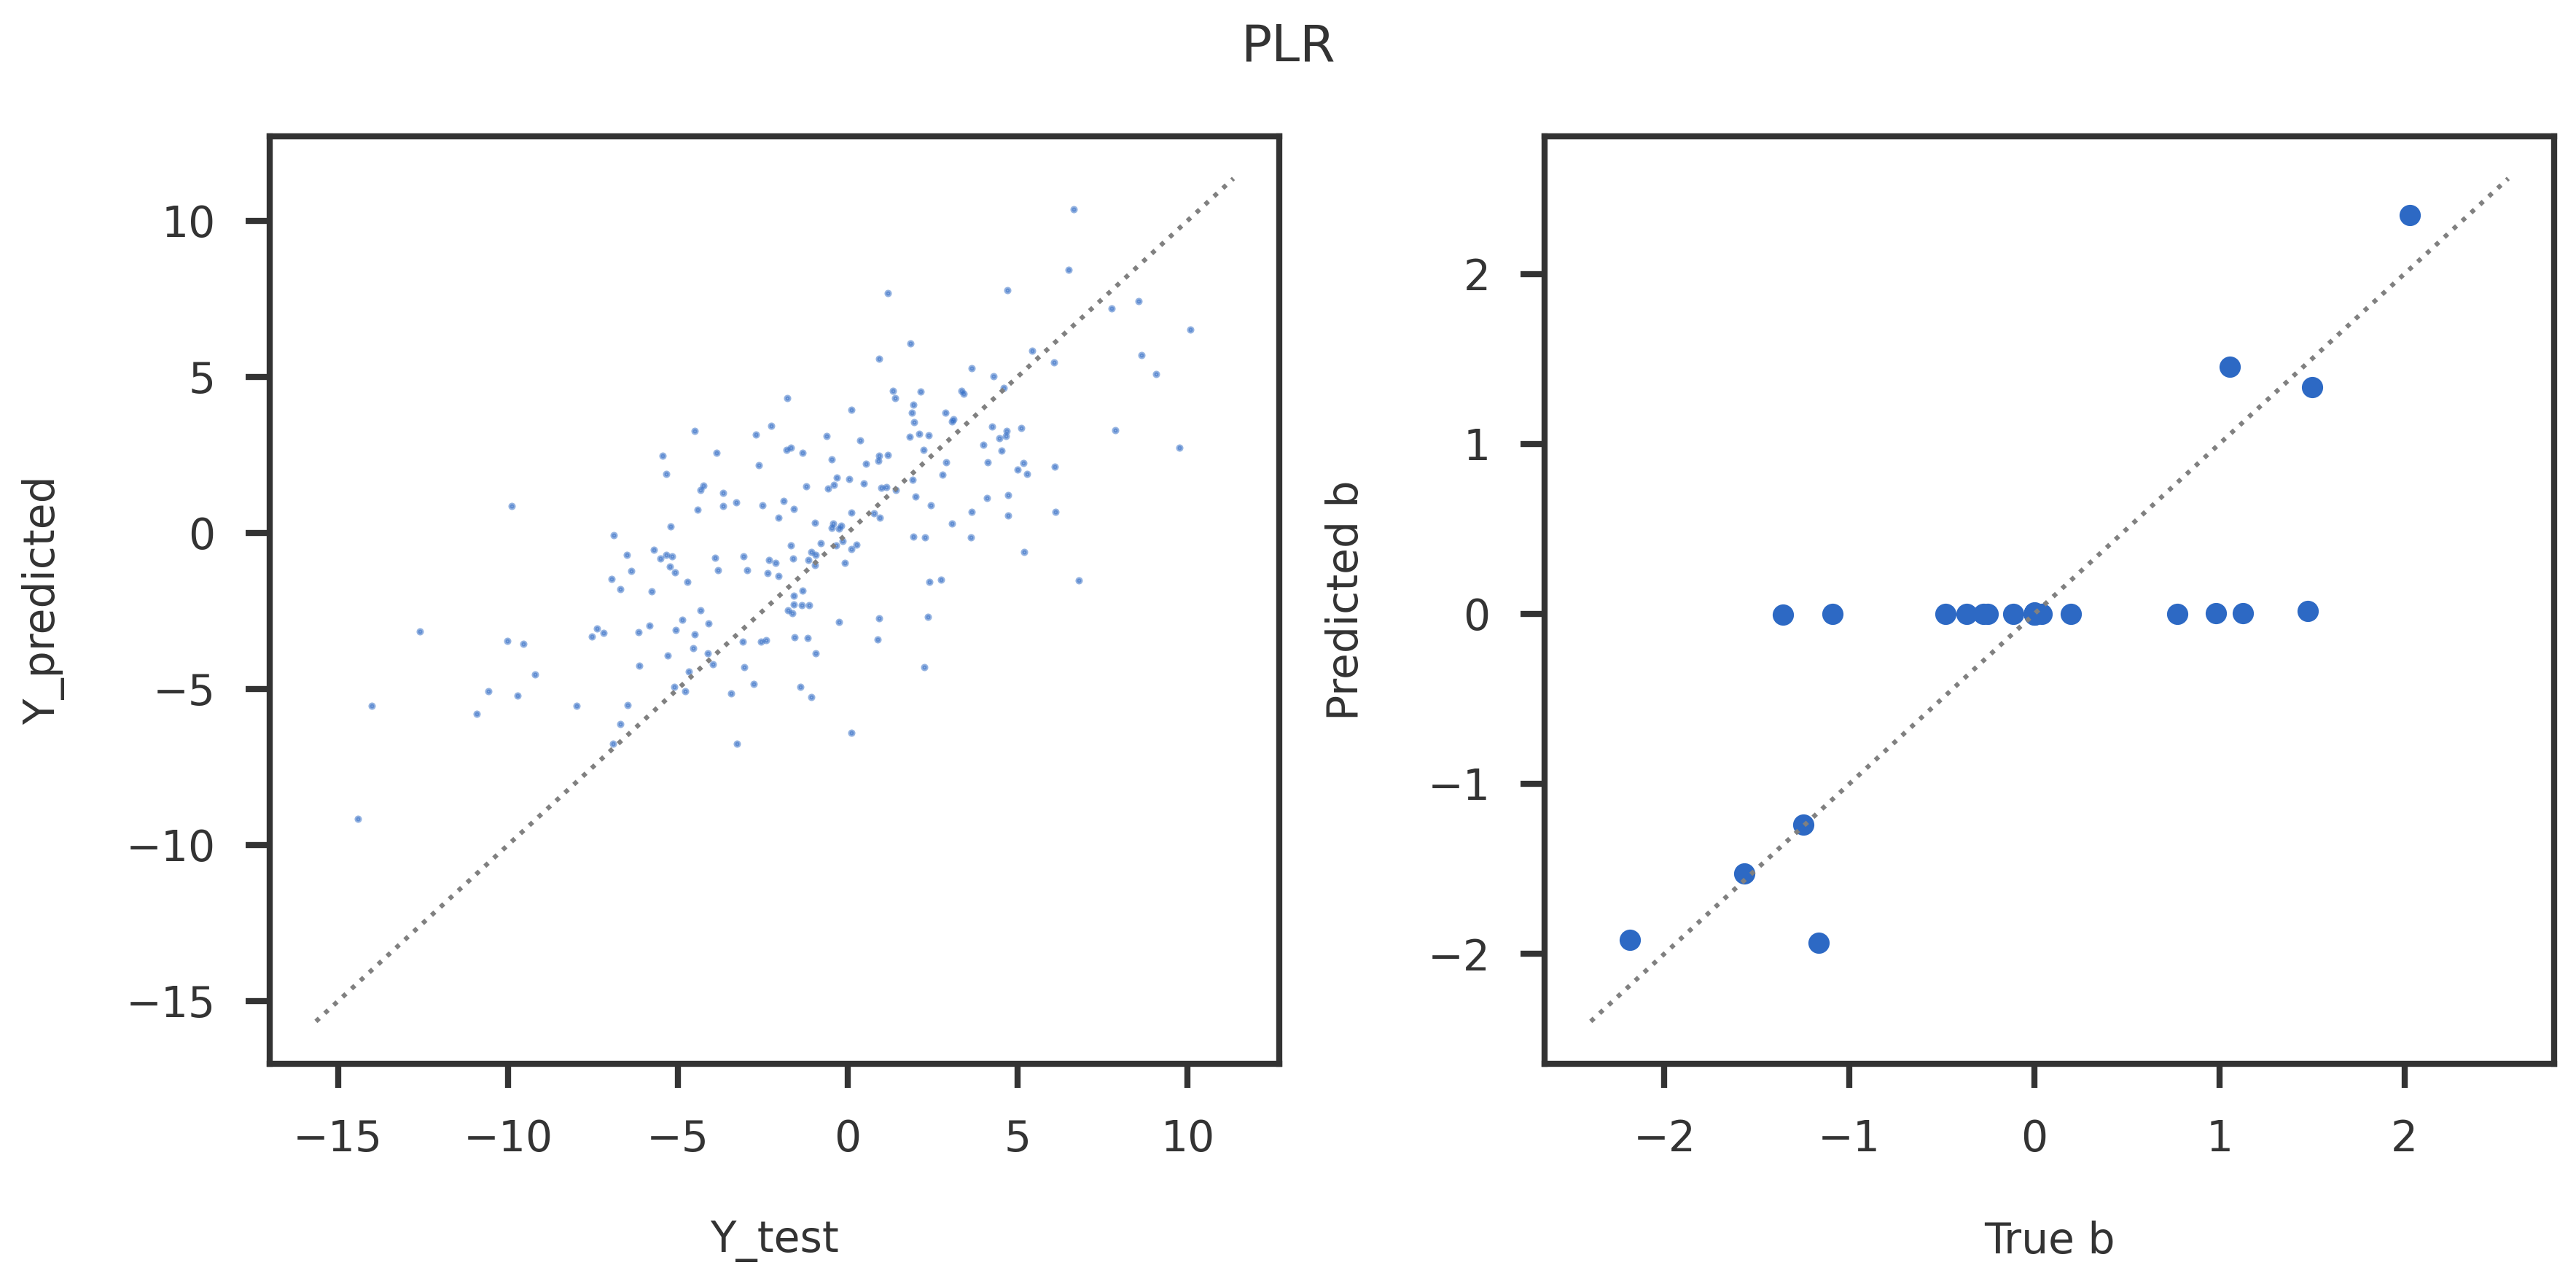

In [4]:
## Optimize
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'PLR')

Mr.ASH terminated at iteration 639.


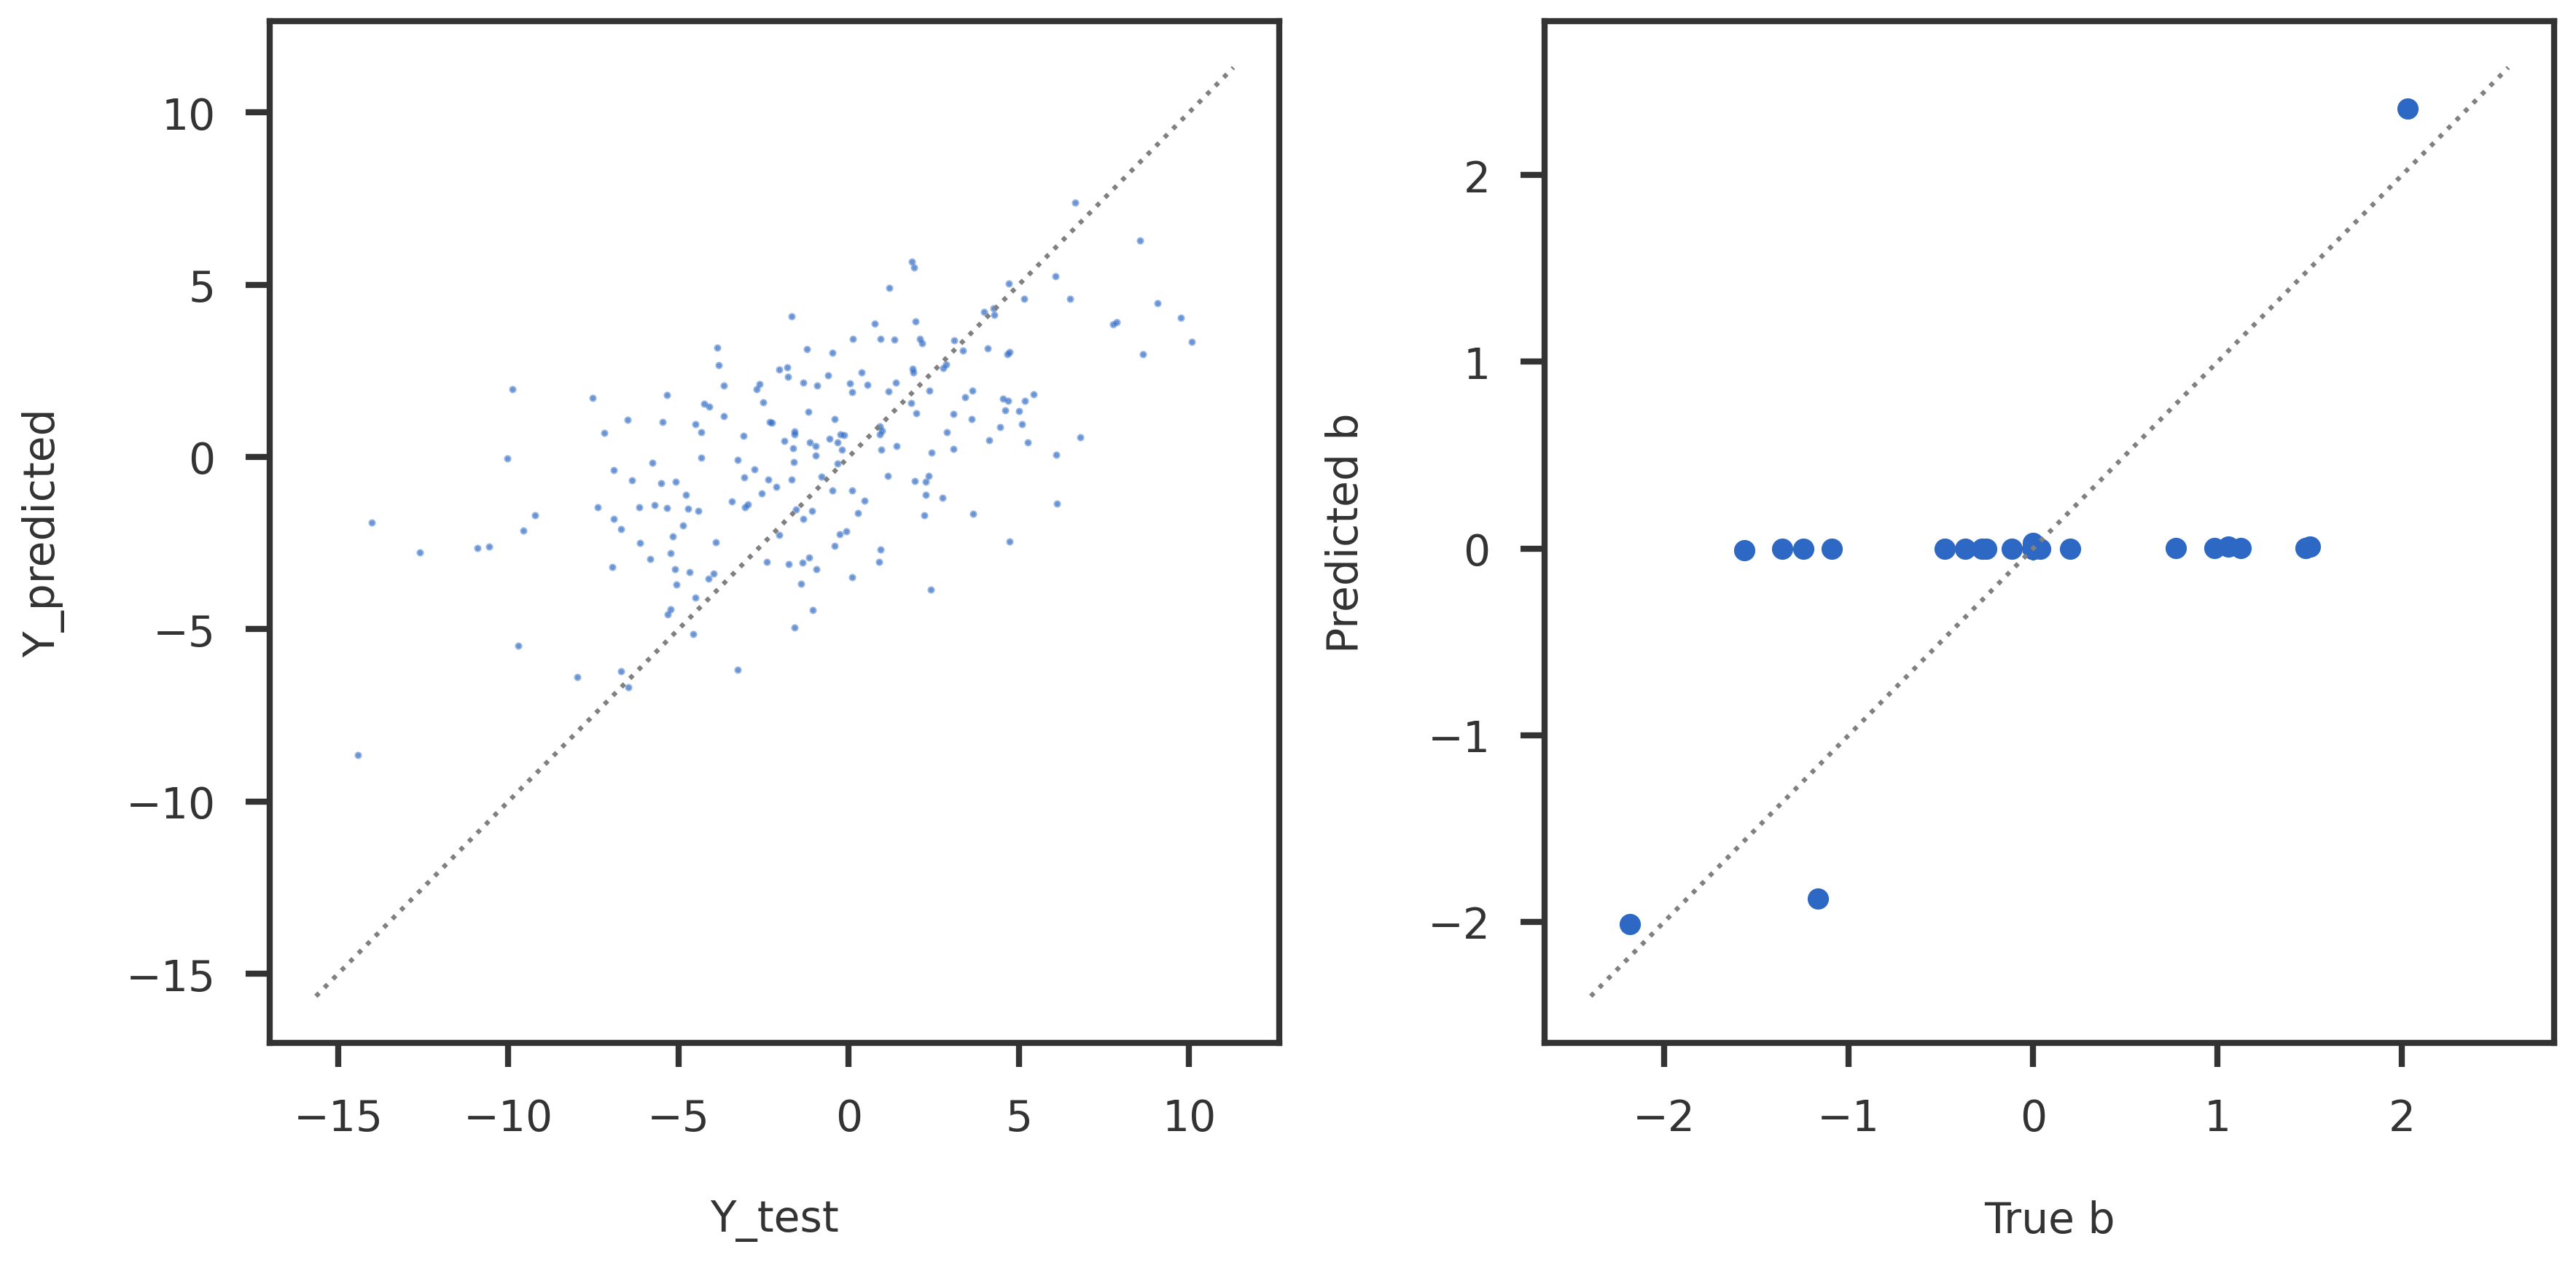

In [5]:
## Mr.ASH.alpha on optimized result
mrash_r = MrASHR(option = "r2py", debug = True)
mrash_r.fit(X, y, sk, 
            binit = np.zeros(p), winit = wk, s2init = 1)

## Plot
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, mrash_r.coef, intercept = mrash_r.intercept)

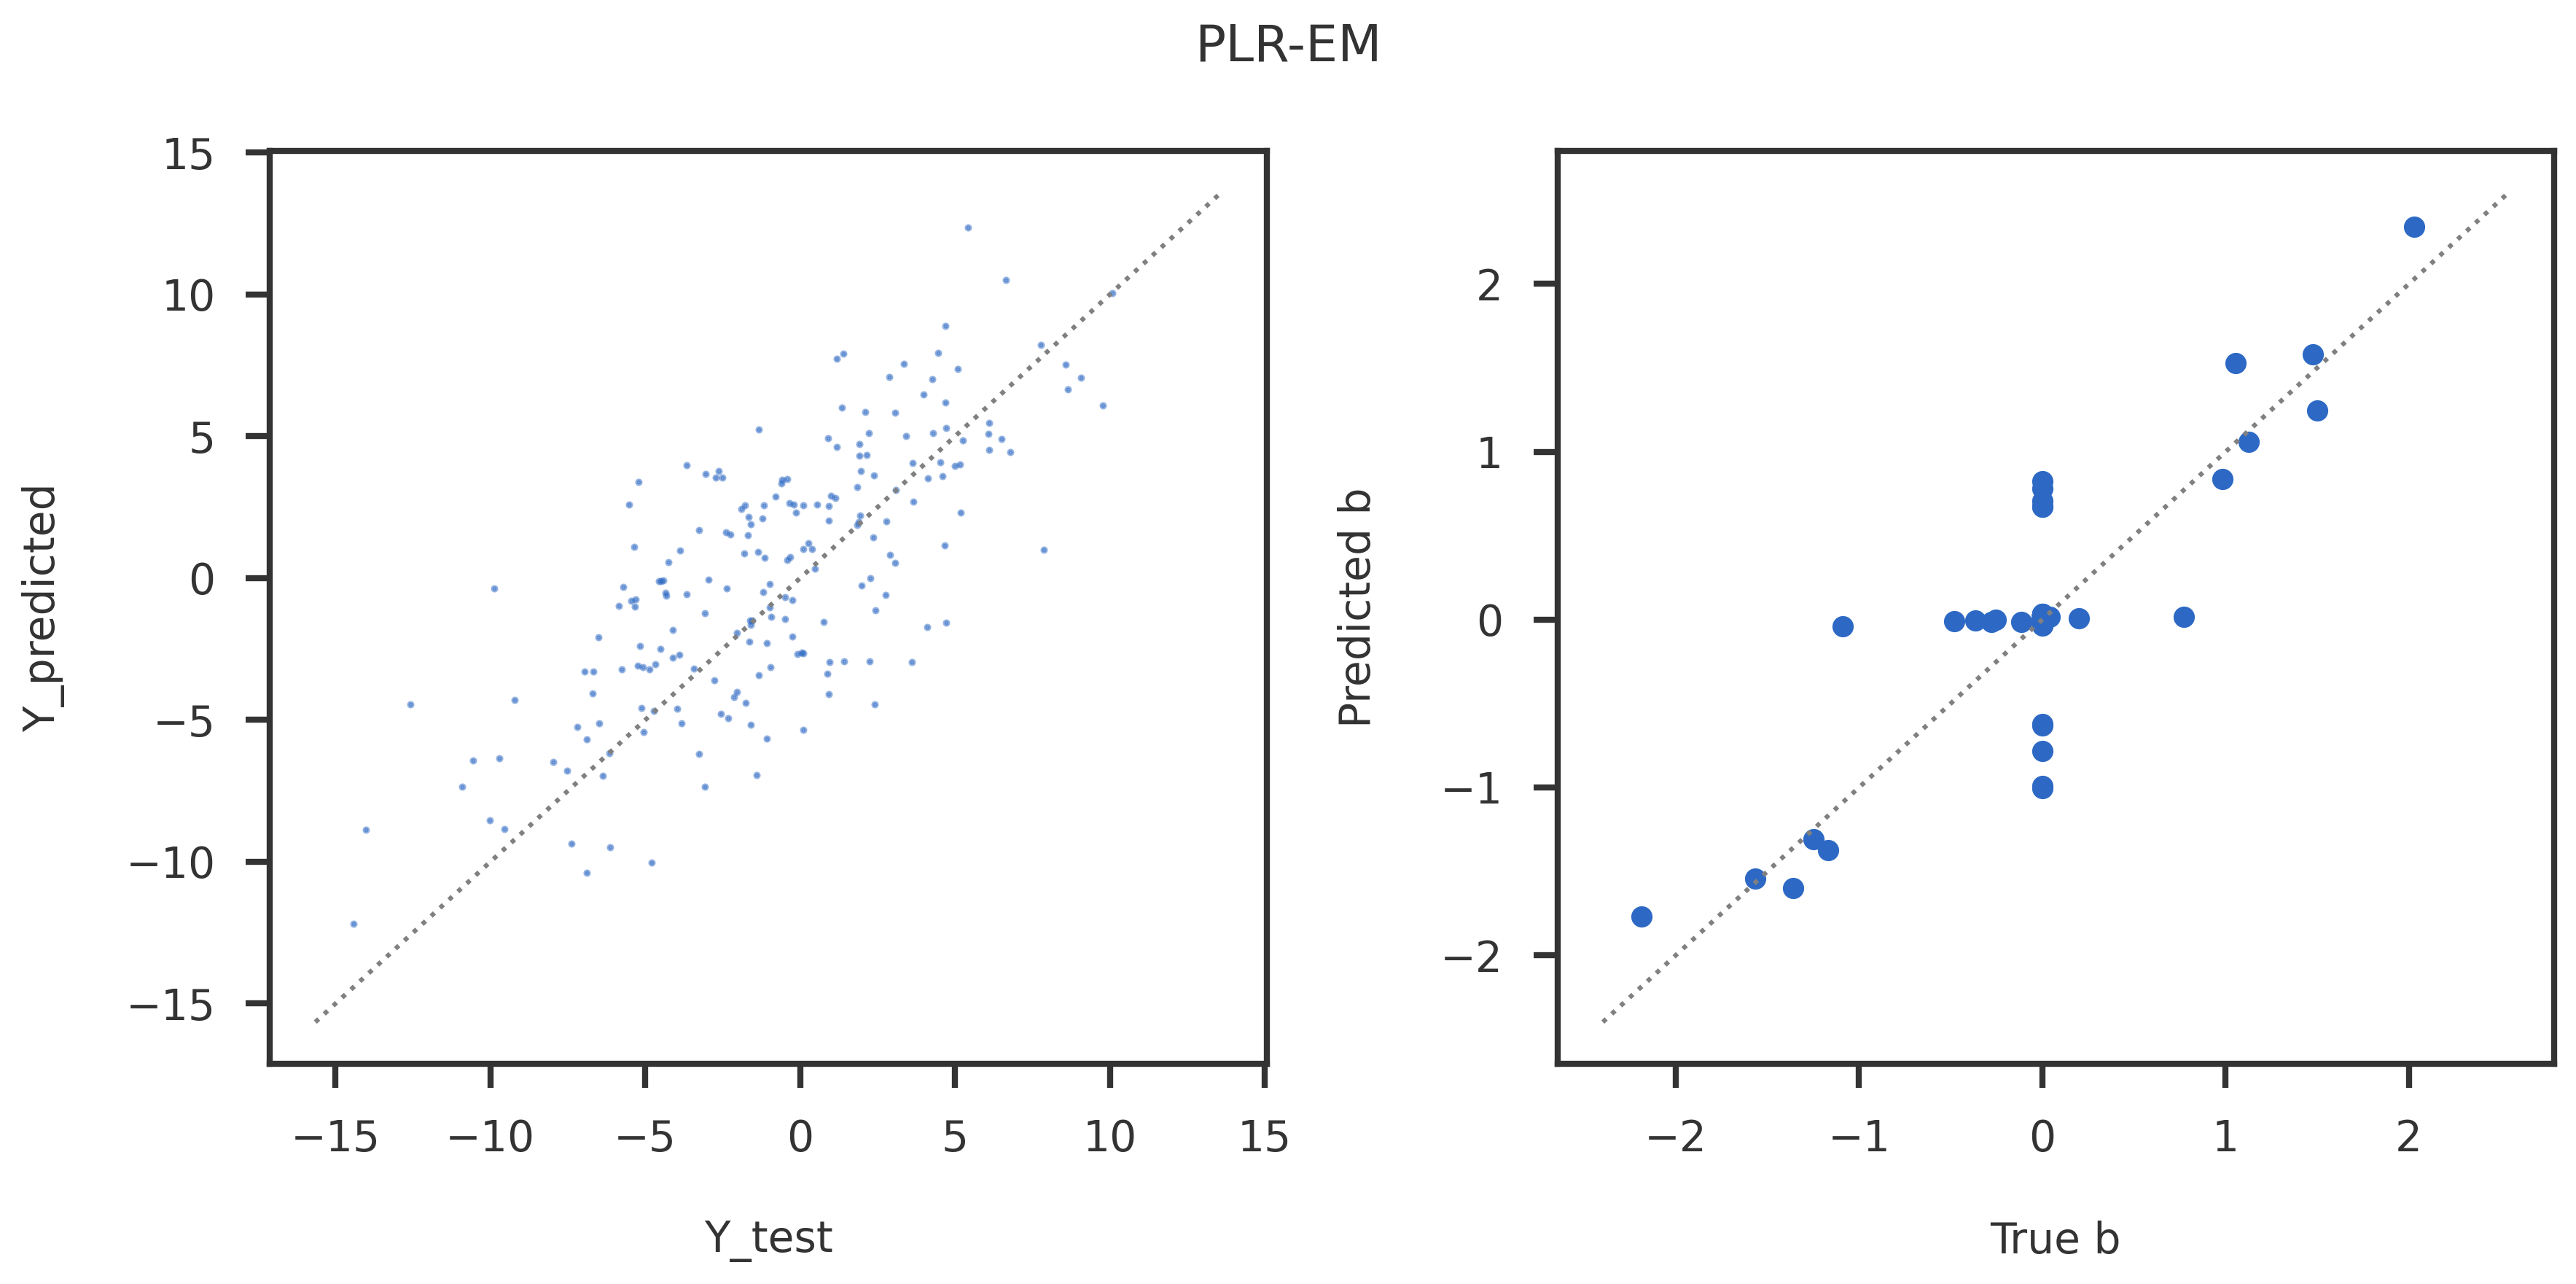

In [6]:
plr_eb = ebfit(X, y, sk, wk, binit = None, s2init = 1, maxiter = 200, qb_maxiter = 100)

plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'PLR-EM')

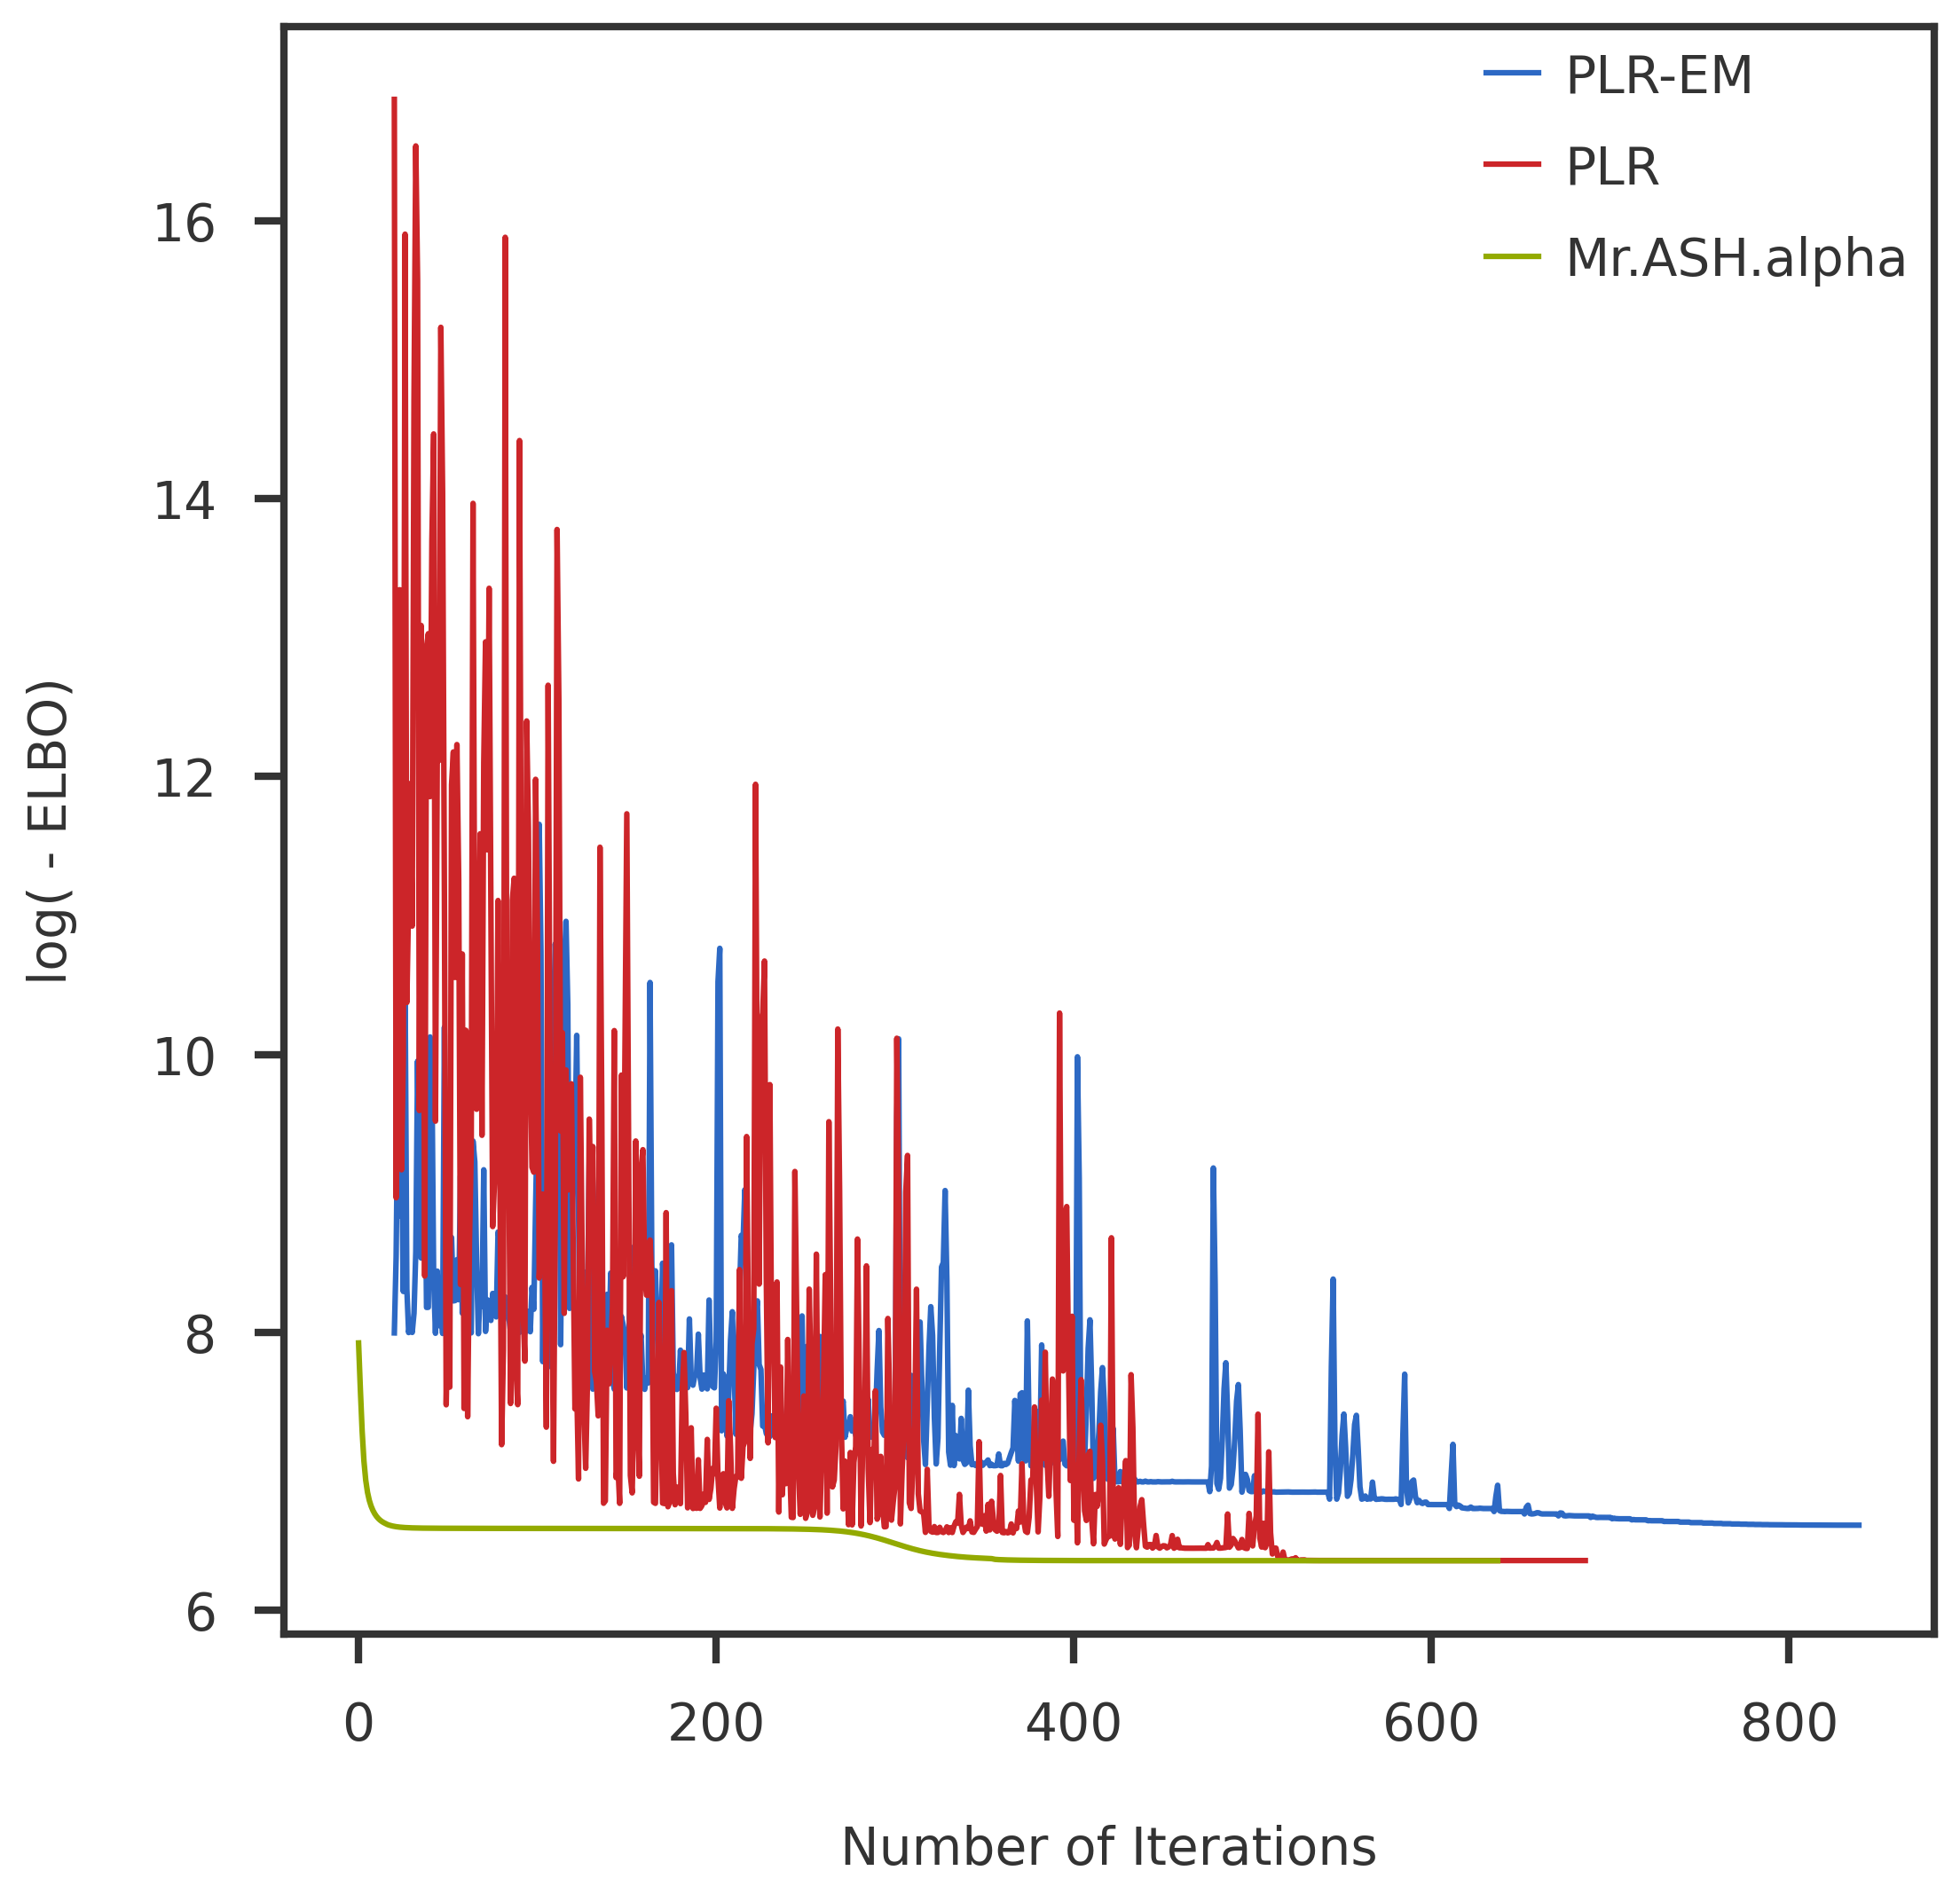

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

kinit   = [20, 20, 0]
objs    = [plr_eb.elbo_path, plr_lbfgs.elbo_path, mrash_r.obj_path]
methods = ["PLR-EM", "PLR", "Mr.ASH.alpha"]
objmin  = np.min([np.min(x) for x in objs])

for obj, method, iteq in zip(objs, methods, kinit):
    ax1.plot(range(iteq, len(obj) - 1), np.log(obj[iteq:-1]), label = method)
ax1.legend()

ax1.set_xlabel("Number of Iterations")
ax1.set_ylabel("log( - ELBO)")

plt.show()

In [8]:
def b_to_theta(X, y, b):
    n, p = X.shape
    r  = y - np.mean(y) - np.dot(X, b)
    rj = r.reshape(n, 1) + X * b.reshape(1, p)
    dj = np.sum(np.square(X), axis = 0)
    theta = np.einsum('ij,ij->j', X, rj) / dj
    return theta

    
def ebfit_debug(X, y, sk, binit = None, winit = wk, s2init = 1, maxiter = 1000):
    n, p = X.shape
    k    = sk.shape[0]
    if binit is None: binit = np.zeros(p)
    intercept = np.mean(y)
    y    = y - intercept
    dj   = np.sum(np.square(X), axis = 0)

    niter = 0
    w  = wk
    s2 = s2init
    b  = binit
    r  = y - np.dot(X, b)
    elbo_path = list()
    obj_path  = list()
    theta = b.copy()
    
    for it in range(maxiter):
        
        ### Remember old parameters
        bold  = b.copy()
        wold  = w.copy()
        rold  = r.copy()
        s2old = s2
        thetaold = theta.copy()
        
        ### Update b
        plr = PLR(method = 'L-BFGS-B', optimize_w = False, optimize_s = False, is_prior_scaled = True,
                  debug = False, display_progress = False, calculate_elbo = True, maxiter = 50)
        plr.fit(X, y, sk, binit = theta, winit = w, s2init = s2)
        b = plr.coef
        theta = plr.theta
        r = y - np.dot(X, b)
        elbo_path += plr.elbo_path
        obj_path  += plr.obj_path
        
        ### Update w
        btilde = b + np.dot(X.T, r) / dj
        nmash = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
        phijk, mujk, varjk = nmash.posterior()        
        w = np.sum(phijk, axis = 0) / p
        #print(w)
        
        ### Update s2
        bbar   = np.sum(phijk * mujk, axis = 1)
        a1     = np.sum(dj * bbar * btilde)
        varobj = np.dot(r, r) - np.dot(np.square(b), dj) + a1
        s2     = (varobj + p * (1 - w[0]) * s2old) / (n + p * (1 - w[0]))
        
        ### Convergence
        
    return b, w, s2, intercept, elbo_path, obj_path